In [227]:
import netCDF4 as nc
import numpy as np
import pydap.client
import geojson
import pandas as pd
import datetime

In [89]:
%%time
'''import meteo data from opendap'''

meteo_url = r"http://opendap.tudelft.nl/thredds/dodsC/data2/zandmotor/meteohydro/meteo/meteo/meteo.nc"
#meteo_url = r"meteo.nc"
meteo_data = nc.Dataset(meteo_url)

d = {}

time = meteo_data.variables['Timestamp']
time_units = "seconds since 1970-01-01 00:00:00 0:00"
print(time_units)
timeDT = list(map(str, nc.num2date(time[:], units=time_units).tolist()))

seconds since 1970-01-01 00:00:00 0:00
Wall time: 22.2 s


In [7]:
array = meteo_data.variables["RelHumidity_Avg"][:].tolist()
print (array[500000:750000])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [106]:
meteo_data.variables

OrderedDict([('Timestamp', <class 'netCDF4._netCDF4.Variable'>
              float64 Timestamp(time)
                  comment: 
                  units: seconds from 1 January 1970
                  standard_name: time
                  coordinates: time
                  long_name: timestamp
              unlimited dimensions: 
              current shape = (1780510,)
              filling off), ('AirTemp_Avg', <class 'netCDF4._netCDF4.Variable'>
              float64 AirTemp_Avg(time)
                  comment: 
                  units: K
                  standard_name: air_temperature
                  coordinates: time
                  long_name: Air temperature on average
              unlimited dimensions: 
              current shape = (1780510,)
              filling off), ('RelHumidity_Avg',
              <class 'netCDF4._netCDF4.Variable'>
              float64 RelHumidity_Avg(time)
                  comment: 
                  units: %
                  standard_name: rel

In [234]:
%%time
d = {}
d['time'] = timeDT
d['lat']  = meteo_data.geospatial_lat_min
d['lon'] = meteo_data.geospatial_lon_min

wanted = ["RelHumidity_Avg", "WindSpeed_Avg"]

df = pd.DataFrame()
df['time'] = timeDT[:]

for name in wanted:
    array = meteo_data.variables[name][:]
    print('processing',name,len(array))
    idx = np.isnan(array)
    new_array = np.array(array, dtype=object)
    new_array[np.nonzero(idx)[0]] = None
    array[array >= 1000] = None   
    
    #print(np.sum(np.isnan(array)))
    d[name] = {"data": array.tolist(),
               "longname": meteo_data.variables[name].long_name,
               "units": meteo_data.variables[name].units}
    df[name] = d[name]['data']

# style dataframe
df.set_index(df.time,inplace=True)
df.index = pd.to_datetime(df.index)
df = df.resample('h').mean()

# put to dictionary
times = []
for i in range(len(df)):
    times.append(datetime.datetime.strftime(df.index[i],'%Y-%m-%d %H:%M:%S'))
d['time'] = times
    
for name in wanted:
    array = df[name].values[:]
    array[np.isnan(array)] = -999
    d[name] = array.tolist()

processing RelHumidity_Avg 1780510


C:\ProgramData\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
C:\ProgramData\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater_equal


processing WindSpeed_Avg 1780510
Wall time: 2.68 s


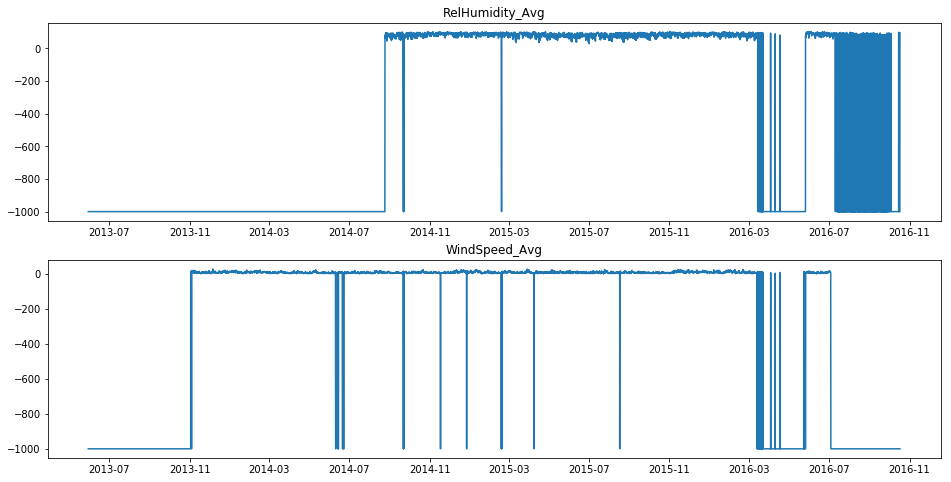

In [209]:
plt.figure(figsize=(16,8))
plt.subplot(211)
plt.title('RelHumidity_Avg')
plt.plot(df.index,df['RelHumidity_Avg'])

plt.subplot(212)
plt.title('WindSpeed_Avg')
plt.plot(df.index,df['WindSpeed_Avg'])

plt.show()

In [235]:
#### %time
import json  
with open('../static/meteo_data_test1.json', 'w') as f:
    json.dump(d, f)

<_io.TextIOWrapper name='meteo_data_test1.json' mode='w' encoding='cp1252'>


In [27]:
'''import wind data from opendap'''
wind_url = "http://opendap.tudelft.nl/thredds/dodsC/data2/zandmotor/meteohydro/wind/wind.nc"
wind_data = nc.Dataset(wind_url)
lat = float(np.squeeze(wind_data.variables['lat'][:]))
lon = float(np.squeeze(wind_data.variables['lon'][:]))
direc = np.squeeze(wind_data.variables['direction'][:]).tolist()
aspeed = np.squeeze( wind_data.variables['average_speed'][:]).tolist()

time = wind_data.variables['time']

timeDT = list(map(str, nc.num2date(time[:], units=time.units).tolist()))
print (time.units)

seconds since 1970-01-01 00:00:00 0:00


In [72]:
import json
jsonlist = dict({'lat': lat, 'lon': lon, 'direc': direc, 'aspeed': aspeed, 'time': timeDT})
with open('wind_data.json', 'w') as f:
    json.dump(jsonlist, f)

NameError: name 'lat' is not defined